In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260211-1755_2q_qst


# CONNECTION

In [3]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.11 22:09:01.965] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 22:09:01.967] INFO    VERSION: laboneq 25.10.3
[2026.02.11 22:09:01.969] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 22:09:02.007] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 22:09:02.059] INFO    Configuring the device setup
[2026.02.11 22:09:02.160] INFO    The device setup is configured


### Linear Phase Delay

In [ ]:
from experiments import linear_phase_delay


#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

#######################################################################
options = linear_phase_delay.experiment_workflow.options()
options.count(1024)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
phase_delay = linear_phase_delay.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(5e6,65e6,201), # Use off resonance window
    options=options,
    temporary_parameters=temporary_parameters
)

phase_delay_result = phase_delay.run() 
print(phase_delay_result.tasks['analysis_workflow'].output)

# Dispersive Shift

- linear phase delay(τ)는 별도 캘리브레이션 모듈에서 구해 고정값으로 전달


$$
\phi_{\text{delay}}(f)=2\pi (f-f_{\text{ref}})\tau + \phi_0
$$

In [4]:
from experiments import dispersive_shift


#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

#temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(256)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-3e6,3e6,101), #fine sweep 해야 기울기 잘 찾음
    options=options,
    phase_delay=93.258e-9,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

DRIVE range (dBm) : 10, READOUT range (dBm) : 0
[2026.02.11 22:09:04.687] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 22:09:04.688] INFO      Workflow 'dispersive_shift': execution started at 2026-02-11                  
[2026.02.11 22:09:04.688] INFO      13:09:04.687009Z                                                              
[2026.02.11 22:09:04.689] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 22:09:04.703] INFO    Task 'temporary_qpu': started at 2026-02-11 13:09:04.703127Z
[2026.02.11 22:09:04.705] INFO    Task 'temporary_qpu': ended at 2026-02-11 13:09:04.704790Z
[2026.02.11 22:09:04.709] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 22:09:04.709] INFO    13:09:04.708906Z
[2026.02.11 22:09:04.710] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 13:09:04.710240Z
[2026.02.11 22:09:04.711] INFO    Tas

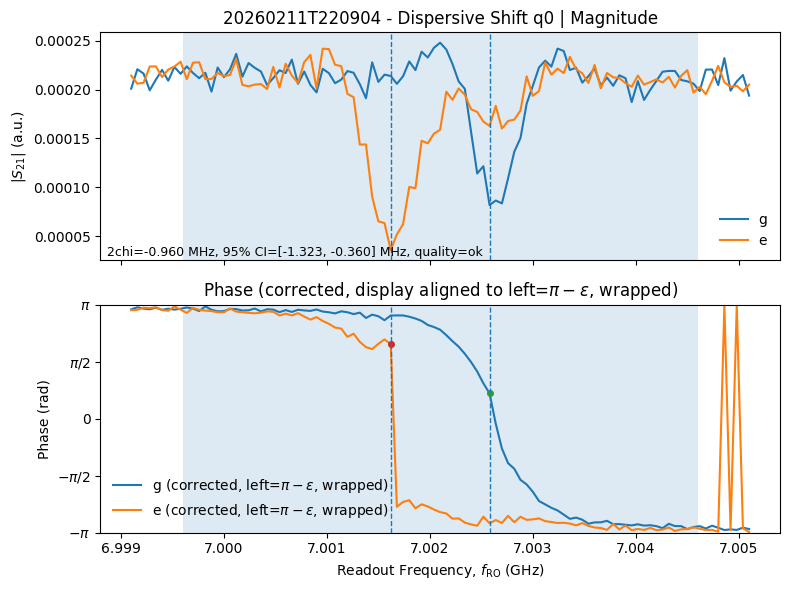

In [5]:

dispersive_result.tasks['analysis_workflow'].tasks['plot_dispersive_shift'].output

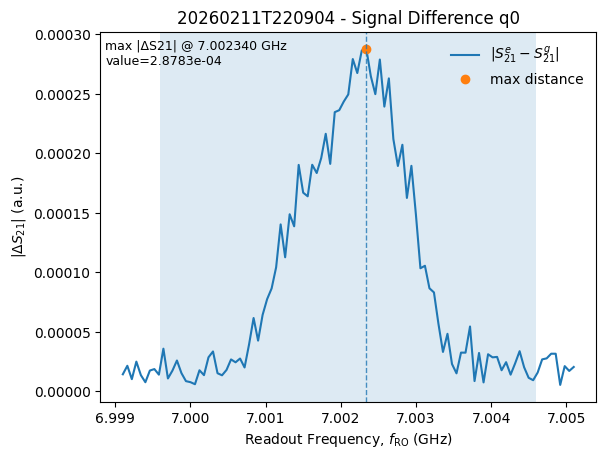

In [6]:

dispersive_result.tasks['analysis_workflow'].tasks['plot_signal_distances'].output


# QuTiP Synthetic Validation (dispersive_shift)

아래 셀들은 **기존 셀을 건드리지 않고** QuTiP로 synthetic `S21(g/e)`를 생성해서 `analysis/dispersive_shift.py`의 추정값(`2chi`, CI, frequency window)을 검증합니다.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

from analysis import dispersive_shift as dispersive_shift_analysis
from laboneq.dsl.result import Results, AcquiredResult, AcquiredResults
from laboneq.simple import dsl
from laboneq_applications.analysis.options import BasePlottingOptions


def make_qutip_synthetic_dispersive_result(
    qubit_uid: str,
    frequencies_hz: np.ndarray,
    *,
    fr_center_hz: float = 7.050e9,
    chi_hz: float = 2.40e6,
    kappa_tot_hz: float = 2.8e6,
    kappa_ext_hz: float = 1.7e6,
    drive_input_amp: float = 1.0e3,
    readout_gain: complex = 1.0 + 0.2j,
    n_fock: int = 14,
    tau_s: float = 18e-9,
    phi0_rad: float = 0.35,
    noise_std: float = 2.0e-3,
    seed: int = 1234,
):
    """Generate synthetic dispersive-shift traces using QuTiP + input-output S21.

    Model:
      H = 2pi*Delta*a^dag a + i*2pi*sqrt(kappa_ext)*Ain*(a^dag-a)
      S21 ~= gain * (1 - sqrt(kappa_ext)*<a>/Ain)

    This yields a realistic complex resonance circle and phase roll near resonance.
    """
    if kappa_ext_hz <= 0 or kappa_tot_hz <= 0:
        raise ValueError("kappa_tot_hz and kappa_ext_hz must be positive.")

    freqs = np.asarray(frequencies_hz, dtype=float)
    rng = np.random.default_rng(seed)

    a = qt.destroy(n_fock)
    adag = a.dag()
    c_ops = [np.sqrt(2 * np.pi * kappa_tot_hz) * a]

    def cavity_s21(fr_hz: float) -> np.ndarray:
        vals = np.zeros_like(freqs, dtype=np.complex128)
        for i, f_hz in enumerate(freqs):
            delta_hz = f_hz - fr_hz
            h = (
                2 * np.pi * delta_hz * (adag * a)
                + 1j * 2 * np.pi * np.sqrt(kappa_ext_hz) * drive_input_amp * (adag - a)
            )
            rho_ss = qt.steadystate(h, c_ops, method="direct")
            a_ss = qt.expect(a, rho_ss)
            s21 = readout_gain * (1.0 - np.sqrt(kappa_ext_hz) * a_ss / max(drive_input_amp, 1e-15))
            vals[i] = s21
        return vals

    fr_g = fr_center_hz - chi_hz
    fr_e = fr_center_hz + chi_hz

    s21_g_clean = cavity_s21(fr_g)
    s21_e_clean = cavity_s21(fr_e)

    phase_ramp = np.exp(1j * (2 * np.pi * (freqs - np.mean(freqs)) * tau_s + phi0_rad))
    noise_g = noise_std * (rng.normal(size=freqs.size) + 1j * rng.normal(size=freqs.size))
    noise_e = noise_std * (rng.normal(size=freqs.size) + 1j * rng.normal(size=freqs.size))

    s21_g = s21_g_clean * phase_ramp + noise_g
    s21_e = s21_e_clean * phase_ramp + noise_e

    acquired = AcquiredResults()
    axis_name = [f"frequency_{qubit_uid}"]
    axis = [freqs]
    acquired[dsl.handles.result_handle(qubit_uid, suffix="g")] = AcquiredResult(
        data=s21_g,
        axis_name=axis_name,
        axis=axis,
    )
    acquired[dsl.handles.result_handle(qubit_uid, suffix="e")] = AcquiredResult(
        data=s21_e,
        axis_name=axis_name,
        axis=axis,
    )

    result = Results(acquired_results=acquired)
    clean_sep_max = float(np.max(np.abs(s21_e_clean - s21_g_clean)))
    truth = {
        "f_r_g_hz": fr_g,
        "f_r_e_hz": fr_e,
        "two_chi_hz": 2.0 * chi_hz,
        "phase_delay": {
            "tau_s": tau_s,
            "phi0_rad": phi0_rad,
            "f_ref_hz": float(np.mean(freqs)),
        },
        "signal_scale": {
            "clean_max_separation": clean_sep_max,
            "noise_std": float(noise_std),
            "approx_snr": clean_sep_max / max(noise_std, 1e-15),
        },
    }
    return result, truth


def mhz(x):
    return float(x) / 1e6



In [ ]:
# Use the real qubit object from existing setup cells
q = qubits[0]
freqs = np.linspace(7.020e9, 7.080e9, 101)

synthetic_result, truth = make_qutip_synthetic_dispersive_result(
    qubit_uid=q.uid,
    frequencies_hz=freqs,
    fr_center_hz=7.050e9,
    chi_hz=2.40e6,
    kappa_tot_hz=2.8e6,
    kappa_ext_hz=1.7e6,
    drive_input_amp=1.0e3,
    readout_gain=1.0 + 0.2j,
    tau_s=18e-9,
    phi0_rad=0.35,
    noise_std=2.0e-3,
    seed=1234,
)

scale = truth["signal_scale"]
print(
    f"Synthetic scale: clean_max_sep={scale['clean_max_separation']:.4f}, "
    f"noise_std={scale['noise_std']:.4f}, approx_SNR={scale['approx_snr']:.1f}"
)

metrics_no_delay = dispersive_shift_analysis.calculate_dispersive_shift_metrics(
    qubit=q,
    result=synthetic_result,
    frequencies=freqs,
    states=["g", "e"],
    phase_delay=None,
    bootstrap_samples=200,
    bootstrap_seed=7,
    confidence_level=0.95,
    window_k_chi=4.0,
    window_min_span_hz=5e6,
)

metrics_with_delay = dispersive_shift_analysis.calculate_dispersive_shift_metrics(
    qubit=q,
    result=synthetic_result,
    frequencies=freqs,
    states=["g", "e"],
    phase_delay=truth["phase_delay"],
    bootstrap_samples=200,
    bootstrap_seed=7,
    confidence_level=0.95,
    window_k_chi=4.0,
    window_min_span_hz=5e6,
)

print(f"True 2chi: {mhz(truth['two_chi_hz']):.3f} MHz")
for tag, m in [("No delay correction", metrics_no_delay), ("With delay correction", metrics_with_delay)]:
    ci = m["two_chi_uncertainty"]
    in_ci = ci["ci_low"] <= truth["two_chi_hz"] <= ci["ci_high"]
    win = m["frequency_window"]
    print(f"\n[{tag}]")
    print(f"  2chi estimate: {mhz(m['two_chi_hz']):.3f} MHz")
    print(f"  95% CI: [{mhz(ci['ci_low']):.3f}, {mhz(ci['ci_high']):.3f}] MHz (contains truth={in_ci})")
    print(f"  quality_flag: {m['quality_flag']}")
    print(f"  window [low, center, high] (GHz): [{win['f_low_hz']/1e9:.6f}, {win['f_center_hz']/1e9:.6f}, {win['f_high_hz']/1e9:.6f}]")



In [ ]:
import matplotlib.pyplot as plt
#plt.plot(np.abs(synthetic_result['q0'].result['e'].data))
plt.plot(synthetic_result['q0'].result['e'].data.real, synthetic_result['q0'].result['e'].data.imag)

In [ ]:
# Module-native visualization (artifact 저장 비활성화)
plot_opts = BasePlottingOptions(save_figures=False, close_figures=False)

fig_a = dispersive_shift_analysis.plot_dispersive_shift(
    qubit=q,
    metrics=metrics_with_delay,
    options=plot_opts,
)
fig_b = dispersive_shift_analysis.plot_signal_distances(
    qubit=q,
    metrics=metrics_with_delay,
    options=plot_opts,
)
plt.show()


In [ ]:
# Module-native visualization (artifact 저장 비활성화)
plot_opts = BasePlottingOptions(save_figures=False, close_figures=False)

fig_a = dispersive_shift_analysis.plot_dispersive_shift(
    qubit=q,
    metrics=metrics_no_delay,
    options=plot_opts,
)
fig_b = dispersive_shift_analysis.plot_signal_distances(
    qubit=q,
    metrics=metrics_no_delay,
    options=plot_opts,
)
plt.show()

In [ ]:
m = metrics_with_delay
print(m["quality_flag"])
print(m["resonance_method"], m["resonance_hz"])
print(m["two_chi_hz"], m["two_chi_uncertainty"])
